In [1]:
import os
import tempfile

import keras
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.models import Model
from keras.layers import merge
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import Dense, Activation, Flatten, Input, Reshape, Convolution2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras.utils.np_utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec

Using TensorFlow backend.


In [121]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [20]:
df = pd.read_csv('train.csv', encoding='utf-8')

In [49]:
X_train, y_train = df['text'], df['author']

In [4]:
len(X_train), len(y_train)

(19579, 19579)

## Embedding: generate vectors

In [50]:
def process(string_list):
    print(string_list)
    new_list = [clean(nltk.word_tokenize(s)) for s in string_list]
    return new_list

def clean(sentence, stop_words=[], lemm=WordNetLemmatizer()):
    return [x.lower() for x in sentence if x.lower() not in stop_words]

In [25]:
clean(nltk.word_tokenize("I told you alreædy that the car looks nice"))

/Users/emannuelcarvalho/.virtualenvs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  import sys


[u'told', u'alre\ufffd\ufffddy', u'car', u'look', u'nice']

In [124]:
for s in X_train:
    print s
    process([unicode(s, errors='replace')])

In [52]:
sentences = process([x for x in X_train])
vector_size = 70
model = Word2Vec(sentences, size=vector_size, window=10, min_count=1, workers=4)
word_vectors = model.wv
del model

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [53]:
def vectorize_word(word):
    try:
        return word_vectors[word.strip(',.!?\'"').strip(',.!?\'"').lower()]
    except:
        return word_vectors['the']
                            

def vectorize(text):
    return [vectorize_word(w) for w in text.split()]

X_train_vec = [vectorize(text) for text in X_train]

In [54]:
print len(y_train)
y_train = [{'EAP': 0, 'HPL': 1, 'MWS': 2}[y] for y in y_train]
print len(y_train)

19579
19579


In [55]:
X_train_vec = np.array(X_train_vec)
y_train = to_categorical(np.array(y_train), num_classes=3)

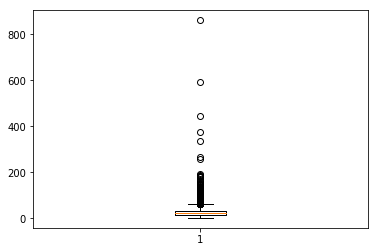

In [56]:
counts = np.array([len(x) for x in X_train_vec])
plt.boxplot(counts)
plt.show()

In [57]:
# truncate and pad input sequences
X_train = X_train_vec
max_length = 200
X_train = sequence.pad_sequences(X_train, maxlen=max_length)

In [70]:
print X_train.shape, y_train.shape

(19579, 200, 70) (19579, 3)


In [60]:
word_vectors.most_similar('good')

[(u'show', 0.982287585735321),
 (u'god', 0.9796628355979919),
 (u'word', 0.9752758741378784),
 (u'pretty', 0.9736962914466858),
 (u"'t", 0.9734954833984375),
 (u'yours', 0.9676824808120728),
 (u'valor', 0.9633820652961731),
 (u'quite', 0.9613347053527832),
 (u'foolish', 0.9610820412635803),
 (u'write', 0.9584431648254395)]

In [61]:
X_train.shape

(19579, 200, 70)

In [77]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))
d2_X_train = Normalizer(copy=False).fit_transform(d2_X_train)
d2_X_train += 1.0
d1_y_train = [{'EAP': 0, 'HPL': 1, 'MWS': 2}[y] for y in df['author']]

clf = MultinomialNB()
clf.fit(d2_X_train, d1_y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [89]:
test_df = pd.read_csv('test.csv')
X_test_text = test_df['text']
X_test = [vectorize(text) for text in X_test_text]
X_test = sequence.pad_sequences(X_test, maxlen=max_length)
nsamples, nx, ny = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny))
d2_X_test = Normalizer(copy=False).fit_transform(d2_X_test)
d2_X_test += 1.0

In [90]:
ids, y_test = [i for i in test_df['id']], clf.predict_proba(d2_X_test)

In [93]:
y_test[1390]

array([ 0.40213821,  0.28979128,  0.30807051])

In [64]:
model = Sequential()
model.add(Dense(512, input_shape=(200, 70), init="uniform", activation="relu"))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))  

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.33, batch_size=32)

/Users/emannuelcarvalho/.virtualenvs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="uniform", input_shape=(200, 70))`
  


Train on 13117 samples, validate on 6462 samples
Epoch 1/10
13117/13117 [==============================] - 194s - loss: 1.0369 - acc: 0.4656 - val_loss: 0.9780 - val_acc: 0.5378
Epoch 2/10
13117/13117 [==============================] - 184s - loss: 0.9673 - acc: 0.5478 - val_loss: 0.9282 - val_acc: 0.5590
Epoch 3/10
13117/13117 [==============================] - 186s - loss: 0.9176 - acc: 0.5824 - val_loss: 0.8910 - val_acc: 0.5853
Epoch 4/10
13117/13117 [==============================] - 190s - loss: 0.8836 - acc: 0.6061 - val_loss: 0.8744 - val_acc: 0.6040
Epoch 5/10
13117/13117 [==============================] - 185s - loss: 0.8549 - acc: 0.6270 - val_loss: 0.8933 - val_acc: 0.6035
Epoch 6/10
13117/13117 [==============================] - 184s - loss: 0.8402 - acc: 0.6345 - val_loss: 0.9172 - val_acc: 0.6051
Epoch 7/10
13117/13117 [==============================] - 189s - loss: 0.8256 - acc: 0.6399 - val_loss: 0.9647 - val_acc: 0.5591
Epoch 8/10
13117/13117 [========================

In [26]:
prediction = model.predict(np.array([X_train[3]]))
print prediction, y_train[3]

[[ 0.48820114  0.15095983  0.36083898]] [ 0.  0.  1.]


In [27]:
test_df = pd.read_csv('test.csv')
X_test_text = test_df['text']

In [28]:
X_test = [vectorize(text) for text in X_test_text]
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [29]:
ids, y_test = [i for i in test_df['id']], model.predict(X_test)

In [30]:
# submission_file = open('submission1.csv', 'w')
file_text = ""
file_text += "id,EAP,HPL,MWS\n"
for data in zip(ids, y_test):
    file_text += "{},{},{},{}\n".format(data[0], data[1][0], data[1][1], data[1][2])
print(file_text[:200])

id,EAP,HPL,MWS
id02310,0.0450474508107,0.0615367554128,0.893415808678
id24541,0.969961106777,0.0161529406905,0.0138858770952
id00134,0.0378526486456,0.716230392456,0.245916977525
id27757,0.83968108892


In [139]:
submission_file = open('submission4.csv', 'w')
submission_file.write(file_text)
submission_file.close()

NameError: name 'file_text' is not defined